# Heart Disease

## Dataset

##### Standaard Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from time import time

import warnings
warnings.filterwarnings("ignore")

##### Data veroveren

Hieronder kun je de eerste vijf rijen van de dataset bekijken. Er is een kolom dat HeartDisease heet. Dit is onze label. Dit bestaat uit twee unieke waarden: 0 en 1. 

0 = false (geen heartdisease)

1 = true  (wel heartdisease)

In [3]:
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Probleem

Hart- en vaatziektes is een verzamennaam voor verschillende ziekten aan het het of aan de bloedvaten. Hart en vaatziektes zijn de belangrijkste doodsoorzaak in Nederland. Dertig procent van alle mensen sterft eraan. 

Ze zijn onder te verdelen in een aantal soorten:
- slechte bloedaanleg
- hartfalen
- hartritmestoornissen
- aangeboren hartziektes
- aandoenlingen aan de hartkleppen

Wat hart- en vaatziekten veroorzaakt verschilt per ziekte. Wel zijn er een aantal factoren die ervoor zorgen dat u meer kans heeft om last te krijgen van hart- en vaatziekten, namelijk: roken, overgewicht, diabetes, hoge bloeddruk en een te hoog cholesterolgehalte.

Hoe cool zou het zijn om van te voren te weten of je een hartziekte hebt of niet? Dat is ook het probleem die ik met dit verslag ga aanpakken. Met behulp van een aantal ML classifiers wordt er bepaald of iemand een hartziekte kan hebben of niet. Er worden drie verschillende modellen getrained: 
- Logistic regression
- Decision Tree Classifier
- Random Forest Tree. 

Een subdoel is om te bepalen wat het verschil nou is tussen deze modellen en welke het best geschikt is voor dit probleem.

Bij hartfalen diagnotiseren is het belangrijk om te kijken of degene die getest is, ook echt correct geclassificeerd is als 'hartziekte'. Daarom wordt er geporobeerd om de recall metric zo hoog mogelijk te verkrijgen. De False Nagetives zijn dus belangrijker dan False Positives.

Formule:
Recall = (TP) / (TP + FN)

In [4]:
data.shape

(918, 12)

In [5]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

**Insights**
- Er zijn 918 rijen en 12 kolommen in de dataset
- Er zijn 5 kolommen die geen getallen zijn. Dit zijn: Sex, ChestpainType, RestingECG, ExerciseAngina en ST_Slope. Deze moeten worden veranderd naar getallen

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


**Insights**
- De meeste patienten zijn tussen de 47 en 60 jaar oud.
- Bij RestingBP is de minimale waarde 0, terwijl 25% van de goep bijvoorbeeld 120 bevat. De gemiddelde is 132. Dit kan dus een uitsmijter zijn. Dezelfde geldt voor de cholesterol-gehalte.
- FastingBS kan wel gewoon minimaal 0 zijn, aanegzien de meeste ook gewoon 0 als waarde hebben.
- Zo'n 55% van de patienten heeft hartproblemen.
- De standaardafwijking van cholelesterol-gehalte is redelijk hoog. er moet dus wel een variatie zijn.

In [7]:
data.describe(include='object').T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


**Insights**

Waar het hier om draait, is vooral de unieke waardes van de categorische values. Zo zijn er 4 verschillende types 'chestpain', wat allemaal van type string is. Dit moet dus veranderd worden naar nummers.

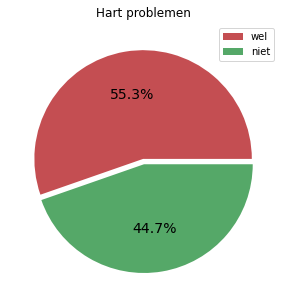

In [8]:
with_disease = data[data['HeartDisease'] == 1]['HeartDisease'].count()
without_disease = data[data['HeartDisease'] == 0]['HeartDisease'].count()

#define Seaborn color palette to use
colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn. Niet dat 90% van de data wel borstkanker heeft en maar 10% niet o.i.d. Je kunt dus zien dat het 
# 40/60 verdeeld is. Dat is nog prima.
plt.figure(figsize=(5,5))
plt.pie([with_disease, without_disease], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['wel','niet'])
plt.title('Hart problemen')
plt.show()

**Insights**

55% van de kandidaten heeft hartproblemen en 45% niet. De dataset is dus goed in balans.

## Voorspelling

**Classifiers**

Ik verwacht dat Random Forest een betere accuracy gaat krijgen dan de Decision Tree, aangezien RF een ensamble is van verschillende Decision Trees. Dit maakt de kans groter dat RF het beter zal doen dan DT.

Ik verwacht ook dat Random Forest een betere accuraatheid gaat gevendan Logistic Regression, aangezien de RF meer accuraatgericht is, maar sloom zal zijn en de Logistic Regression juist op snelheid let. Aangezien LR snel is, denk ik dat het eerder fouten kan maken.

Qua tijd zal Logistic Regression het snelst zijn en Random Forest juist het traagst. LR staat bekend om de snelheid en aangezien RF een set van Decision Trees is, gaat het langer duren dan de DT.

**Hyperparameters**

Qua Logistic Regression denk ik niet dat veel hyperparameters belangrijk zullen worden. Het heeft er ook niet een groot variatie van. Het enige wat ik denk dat belangrijk kan zijn is de solver. Volgens de documentatie van sklearn (zie bronnen) is liblinear een beter geschikt voor kleine datasets (dit is ook een kleine dataset). Ik zal dus deze uitproberen met de standaardwaarde (lbfgs).

Voor DT en RFC lijkt me de volgende hyperparameters van belang:
- max_depth: Default is dit zo lang mogelijk totdat de laatste node 1 waarde bevat. Hiermee kunnen we dus overfitting voorkomen
- max_leaf_nodes: Dit zorgt er ook voor dat de tree varieert in diepte. 
- Ook min_sample_split en min_sample_leaf kunnen een bijdrage geven. Hiermee kunnen we aangeven of split naar nodes wel kan of niet.

Voor RFC geldt ook de volgende:
- n_estimators: aantal decision trees in de forest tree. Dit spreekt voor zich. Meerdere decision trees ensambled hebben een kans op een betere accuracy. Toch capt het na een x aantal trees.
- max_features: Ook dit kan een rol spelen. Door bij elke split een aantal features te pakken i.p.v. alle, zorgt het voor variatie in de hele tree. 




## Methoden

#### Pre-processing

In [9]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
data.duplicated().sum()

0

**Insights**

- Er zijn geen gedupliceerde waarden
- Er zijn geen lege cellen


##### Categorisch -> numeriek

In [11]:
categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()

data[categorical_features] = data[categorical_features].apply(lb.fit_transform)

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


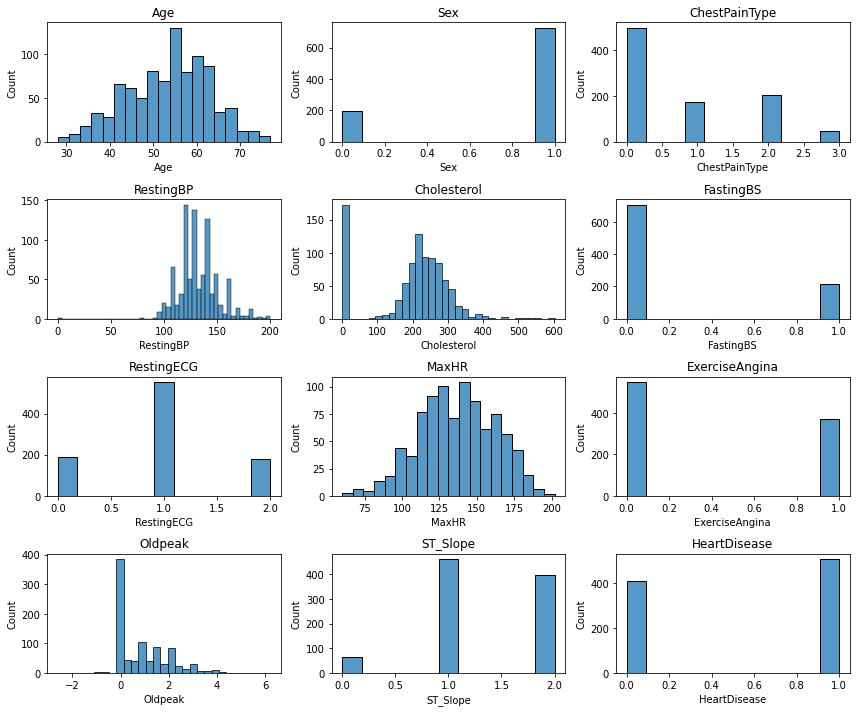

In [12]:
plt.figure(figsize=(12,10))
for idx, column in enumerate(data.columns):
    plt.subplot(4, 3, idx+1)
    sns.histplot(x=column, data=data)
    plt.title(column)
    plt.tight_layout()
plt.show()

**Insights**
- Waardes zoals Age en MaxHR zien er redelijk normaal verdeeld uit.
- Bij cholesterol zijn er heelveel 0 waardes. Dit zijn hoogstwaarschijnlijk uitsmijters, want 0 als waarde voor cholesterol is niet mogelijk.
- Er zijn veel meer mannen met hartproblemen dan vrouwen.
- OldPleak heeft een negatieve waarde. Deze kunnen niet negatief zijn.

Om er zeker van te zijn dat RestingBP en Cholesterol uitsmijters bevat, wordt er hieronder een boxplot getekend.

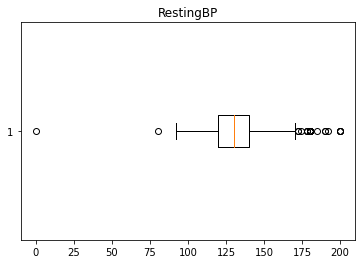

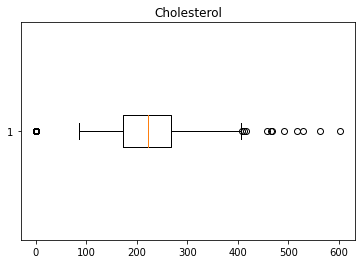

In [13]:
plt.boxplot(data['RestingBP'], vert=False)
plt.title('RestingBP')
plt.show()

plt.boxplot(data['Cholesterol'], vert=False)
plt.title('Cholesterol')
plt.show()

**Insights**

Er zijn inderdaad uitsmijters. 

Er is maar 1 negatieve waarde bij RestingBP (wat niet kan). Ik denk dat dit gewoon een typefout is, want de absolute waarde komt gewoon goed overeen. Deze kunnen we dus veranderen naar de abolute waarde.

Bij cholesterol kan dit niet zomaar. Het zijn er teveel en cholesterol heeft een groot invloed. Aangezien het er te veel zijn en dat het gewoon echt uitsmijters zijn, kan de gemiddelde hier niet gebruikt voor worden. De beste optsie is dus of de mediaan of de modus te gebruiken.

Laten we beginnen met de cholesterol-gehalte. We weten dat 0 niet kan. Ik wil de 0-waardes ook niet weggooien, aangezien de dataset niet al te groot is.

In [15]:
median_cholesterol = data['Cholesterol'].median()
data["Cholesterol"].replace(0, median_cholesterol, inplace=True)
data['Cholesterol'] = data['Cholesterol'].apply(lambda x: x if x < 450 else median_cholesterol)

We hebben net geconcludeerd dat we de absolute waarde kunnen gebruiken voor Oldpeak, aangezien het maar 1 waarde is. Hoogstwaarschijnlijk is dit een typefout.

In [16]:
data.loc[data['Oldpeak'] < 0,'Oldpeak'] = 0.1 # absolute waarde van de oude oldPeak

Last but not least, de RestingBP. Hierbij kunnen we wel gewoon de gemiddelde gebruiken. Dit zal niet veel invloed hebben op de vorige gemiddelde.

In [17]:
mean_restingbp = data['RestingBP'].mean()

data["RestingBP"].replace(0, mean_restingbp, inplace=True)

Aangezien de heatmap een visueel beter is dan normale correlatie tabel, gebruiken we de heatmap in de sns library.

<AxesSubplot:>

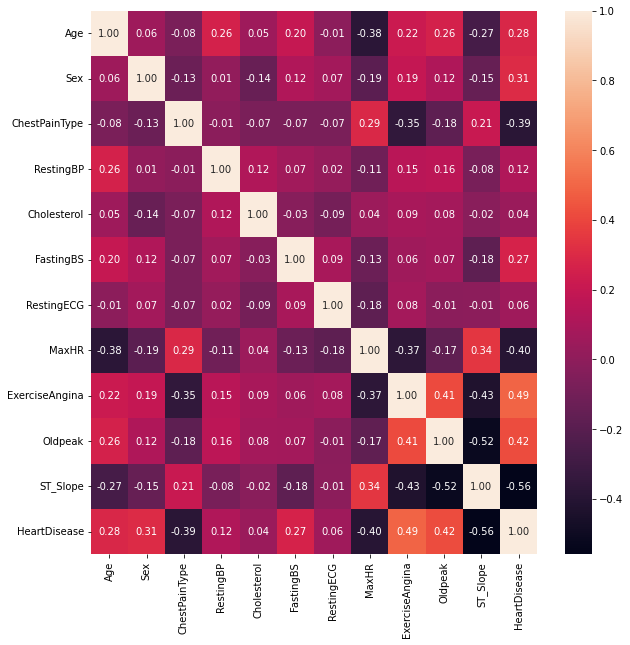

In [18]:
# Visualiseer de correlatie tabel met een heatmap
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

**Insights**

Je kunt zien dat er in de heatmap nu ook gewoon alle kolommen aanwezig zijn. Alle kolommen worden meegenomen in de modellen, aangezien allen direct of indirect veel invloedt hebben op de heartdisease. RestingECG en cholesterol zouden wel wegkunnen, aangezien ze zowel direct als indirect heel weinig invloed hebben.

Op eerste blik lijkt het dat MaxHR, ST_Slope en ExerciseAngina een sterk correlatie te hebben met Heartdisease.

Cholesterol, RestingECG en RestingBP lijken een zwak correlatie te hebben met Heartdisease. 

Conclusie:
- alles gebruiken behalve, Cholesterol, RestingECG en RestingBP

In [19]:
data.shape

(918, 12)

##### Kolmogorov-Smirnov test

H0: De verdeling is een normaal verdeling

In [20]:
from scipy.stats import kstest

In [21]:
kstest(data['Age'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [22]:
kstest(data['Cholesterol'],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [23]:
kstest(data['RestingBP'],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [24]:
kstest(data['FastingBS'],'norm')

KstestResult(statistic=0.5, pvalue=9.62555011802948e-213)

**Insights**
- De kolommen hebben een pvalue lager dan 5% -> reject H0 -> niet normaal verdeeld
- Gebruik Welsch t-test

##### T-Test

We gebruiken de welsch t-test aangezien de dataset niet normaal verdeeld is. Bij de normale t-test is één van de requirements dat het normaal verdeeld moet zijn. Bij de welsch t-test. Als er vegelijkbare variatie is, levert deze hetzelfde resultaat op als de t-test. Zo niet, dan corrigeert deze het.

De t-test van scipy geeft niet heel veel informatie. We missen informatie over de effect size. Pearson R kan ons hierbij helpen. Daarom gebruiken we researchpy. Dit geeft al wat meer inzicht

1. In plaats van correlaties tussen interval variabelen en de target variabele "satisfaction" te berekenen, kan ik t testen doen.
2. In plaats van correlaties tussen nominale variable en de target variabele "satisfaction" te berekenen, kan ik een chi square doen.
3. Als ik een nominale variabele heb, waar wel een rangorde in zit, kan ik een Mann Whitney test doen of eveneens kiezen voor een chi square.

categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

interval_feautures = ['Age', 'RestingBP,', 'Cholesterol', 'FastingBS', 'MaxHR', 'OldPeak']

In [26]:
import researchpy as rp

In [27]:
wel = data[data['HeartDisease'] == 1]
geen = data[data['HeartDisease'] == 0]

##### Cholesterol

In [28]:
rp.ttest(group1=wel['Cholesterol'], group2=geen['Cholesterol'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  239.728346  45.881902  2.035680  235.728939  243.727754
 1      niet  410.0  235.997561  49.195409  2.429588  231.221523  240.773599
 2  combined  918.0  238.062092  47.400535  1.564451  234.991772  241.132411,
                Welch's t-test   results
 0  Difference (wel - niet) =     3.7308
 1       Degrees of freedom =   849.6912
 2                        t =     1.1770
 3    Two side test p value =     0.2395
 4   Difference < 0 p value =     0.8802
 5   Difference > 0 p value =     0.1198
 6                Cohen's d =     0.0787
 7                Hedge's g =     0.0787
 8            Glass's delta =     0.0813
 9              Pearson's r =     0.0403)

**Insights**
- p value > 5%
- Ho wordt behouden, dus er is geen significant verschil
- Pearsons r is zeer zwak
- weggooien

##### Age

In [29]:
rp.ttest(group1=wel['Age'], group2=geen['Age'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0       wel  508.0  55.899606  8.727056  0.387200  55.138891  56.660321
 1      niet  410.0  50.551220  9.444915  0.466451  49.634279  51.468160
 2  combined  918.0  53.510893  9.432617  0.311323  52.899905  54.121881,
                Welch's t-test   results
 0  Difference (wel - niet) =     5.3484
 1       Degrees of freedom =   845.5957
 2                        t =     8.8225
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.5907
 7                Hedge's g =     0.5902
 8            Glass's delta =     0.6129
 9              Pearson's r =     0.2903)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk sterk
- behouden

##### RestingBP

In [30]:
rp.ttest(group1=wel['RestingBP'], group2=geen['RestingBP'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  134.445662  18.910339  0.839011  132.797297  136.094028
 1      niet  410.0  130.180488  16.499585  0.814856  128.578659  131.782317
 2  combined  918.0  132.540737  17.989932  0.593756  131.375458  133.706016,
                Welch's t-test   results
 0  Difference (wel - niet) =     4.2652
 1       Degrees of freedom =   912.4704
 2                        t =     3.6467
 3    Two side test p value =     0.0003
 4   Difference < 0 p value =     0.9999
 5   Difference > 0 p value =     0.0001
 6                Cohen's d =     0.2386
 7                Hedge's g =     0.2384
 8            Glass's delta =     0.2255
 9              Pearson's r =     0.1199)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk zwak
- weggooien

##### FastingBS

In [31]:
rp.ttest(group1=wel['FastingBS'], group2=geen['FastingBS'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       wel  508.0  0.334646  0.472332  0.020956   0.293474  0.375818
 1      niet  410.0  0.107317  0.309894  0.015305   0.077232  0.137403
 2  combined  918.0  0.233115  0.423046  0.013963   0.205713  0.260518,
                Welch's t-test   results
 0  Difference (wel - niet) =     0.2273
 1       Degrees of freedom =   882.9740
 2                        t =     8.7603
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.5573
 7                Hedge's g =     0.5569
 8            Glass's delta =     0.4813
 9              Pearson's r =     0.2828)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk sterk
- behouden

##### MaxHR

In [32]:
rp.ttest(group1=wel['MaxHR'], group2=geen['MaxHR'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  127.655512  23.386923  1.037627  125.616934  129.694090
 1      niet  410.0  148.151220  23.288067  1.150116  145.890344  150.412095
 2  combined  918.0  136.809368  25.460334  0.840316  135.160202  138.458534,
                Welch's t-test   results
 0  Difference (wel - niet) =   -20.4957
 1       Degrees of freedom =   879.0415
 2                        t =   -13.2315
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     0.0000
 5   Difference > 0 p value =     1.0000
 6                Cohen's d =    -0.8780
 7                Hedge's g =    -0.8773
 8            Glass's delta =    -0.8764
 9              Pearson's r =     0.4075)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is sterk
- behouden

##### Oldpeak

In [33]:
rp.ttest(group1=wel['Oldpeak'], group2=geen['Oldpeak'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       wel  508.0  1.297638  1.110269  0.049260   1.200859  1.394417
 1      niet  410.0  0.413415  0.694012  0.034275   0.346038  0.480791
 2  combined  918.0  0.902723  1.043944  0.034455   0.835103  0.970344,
                Welch's t-test   results
 0  Difference (wel - niet) =     0.8842
 1       Degrees of freedom =   866.9220
 2                        t =    14.7343
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.9334
 7                Hedge's g =     0.9327
 8            Glass's delta =     0.7964
 9              Pearson's r =     0.4475)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is sterk
- behouden

##### conclusie

- Age, FastingBS, Oldpeak en MaxHR behouden
- Cholesterol weggooien

#### Nominale kolommen


categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

In [34]:
_, result = rp.crosstab(data['HeartDisease'], data['Sex'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,85.6463
1,p-value =,0.0000
2,Cramer's phi =,0.3054


In [35]:
_, result = rp.crosstab(data['HeartDisease'], data['ChestPainType'], test= "chi-square")

result

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,268.0672
1,p-value =,0.0000
2,Cramer's V =,0.5404


In [36]:
_, result = rp.crosstab(data['HeartDisease'], data['RestingECG'], test= "chi-square")

result

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,10.9315
1,p-value =,0.0042
2,Cramer's V =,0.1091


In [37]:
_, result = rp.crosstab(data['HeartDisease'], data['ExerciseAngina'], test= "chi-square")

result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,224.2809
1,p-value =,0.0000
2,Cramer's phi =,0.4943


In [38]:
_, result = rp.crosstab(data['HeartDisease'], data['ST_Slope'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,355.9184
1,p-value =,0.0000
2,Cramer's V =,0.6227


**Insights**

alle kolommen behlave RestingECG:
- p-value < 0.5
- H0 wordt verworpen, dus er is een significant verschil
- Cramers phi is zeker sterk
- behouden

RestingECG:
- p-value < 0.5
- H0 wordt verworpen, dus er is een significant verschil
- Cramers phi is zwak
- weggooien


Stel nu dat we een target variable hebben met 3 categorieen, bijvoorbeeld we willen voorspellen welke Class iemand vliegt. We willen weten of leeftijd van belang is om te voorspellen welke Class iemand vliegt. Een correlatie is mogelijk, maar is afhankelijk welke klasse welk cijfer krijgt. Bij klasse kun je nog een rangorde voorstellen, maar stel voor dat je religie van de respondent wil voorspellen, dan is een correlatie een rare maat. De oplossing: ANOVA

In [39]:
from scipy.stats import f_oneway
f_oneway(data['Age'][data['ChestPainType'] == 0],
               data['Age'][data['ChestPainType'] == 1],
               data['Age'][data['ChestPainType'] == 2],
               data['Age'][data['ChestPainType'] == 3])

F_onewayResult(statistic=16.86834805144362, pvalue=1.136820472395362e-10)

In [129]:
stats.f_oneway(data['Age'], data['ChestPainType'], data['HeartDisease'])

F_onewayResult(statistic=28440.267407833908, pvalue=0.0)

In [41]:
#Als er een significant verschil is tussen de drie groepen, weten we nog niet welke groepen verschillen
#t toetsen moeten dan duidelijkheid brengen, maar we hebben dan een correctie nodig
# We kiezen hier voor Tukey's correctie

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(data['Age'], data['ChestPainType'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.7169,0.0,-7.807,-3.6268,True
0,2,-1.6493,0.1376,-3.6216,0.3229,False
0,3,-0.1336,0.9997,-3.7819,3.5147,False
1,2,4.0676,0.0001,1.6183,6.5168,True
1,3,5.5833,0.0015,1.6566,9.51,True
2,3,1.5157,0.744,-2.3496,5.381,False


In [47]:
#Een andere veelgebruikte post hoc test is de t test met Bonferroni correctie
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

comp = mc.MultiComparison(data['Age'], data['ChestPainType'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
0,1,7.2796,0.0,0.0,True
0,2,2.1955,0.0285,0.1708,False
0,3,0.0961,0.9235,1.0,False
1,2,-4.1601,0.0,0.0002,True
1,3,-3.4505,0.0007,0.004,True
2,3,-0.9311,0.3527,1.0,False


verwijder onnodige kolommen

In [17]:
data.drop(columns=['RestingECG', 'Cholesterol'], axis=1)

,Age,Sex,ChestPainType,RestingBP,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140.0,0,172,0,0.0,2,0
1,49,0,2,160.0,0,156,0,1.0,1,1
2,37,1,1,130.0,0,98,0,0.0,2,0
3,48,0,0,138.0,0,108,1,1.5,1,1
4,54,1,2,150.0,0,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110.0,0,132,0,1.2,1,1
914,68,1,0,144.0,1,141,0,3.4,1,1
915,57,1,0,130.0,0,115,1,1.2,1,1
916,57,0,1,130.0,0,174,0,0.0,1,1


Split data

In [42]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Tijdens het trainen van logisticRegression, werd er een error gegeven met max number of iterations exeeded. Dit kon je oplossen door de limiet te verhogen of nog beter zelfs, de data te scalen. Het scalen van de dataset is hierbij handig, aangezien StandardScaler afwijkingen weghaald. 

In [43]:
# from sklearn.preprocessing import Normalizer

# normalizer = Normalizer()

# X_train = normalizer.fit_transform(X_train)
# X_test = normalizer.fit_transform(X_test)

# X_train
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Print data
X_train

array([[ 0.9700116 ,  0.51740017,  0.23787636, ...,  1.20277457,
         0.30726655, -0.60472665],
       [ 0.12202766,  0.51740017,  0.23787636, ..., -0.83141099,
        -0.47077104,  1.06395516],
       [ 0.54601963, -1.93273999, -0.80141678, ...,  1.20277457,
         0.59903064, -0.60472665],
       ...,
       [ 0.54601963,  0.51740017, -0.80141678, ...,  1.20277457,
         0.40452125, -2.27340846],
       [ 0.75801561,  0.51740017, -0.80141678, ...,  1.20277457,
        -0.85978984,  1.06395516],
       [-0.93795226,  0.51740017, -0.80141678, ..., -0.83141099,
        -0.85978984,  1.06395516]])

In [65]:
import scipy.stats as stats

zscores = stats.zscore(X_train)

has_higher_than_3 = False

for i in zscores:
    if all(y <=3 for y in i) is False:
        has_higher_than_3 = True
        print(i)


has_higher_than_3

[ 0.9700116   0.51740017 -0.80141678  0.39436224 -1.01030651 -0.5448117
 -1.58841625  0.29528205  1.20277457  3.03039811  1.06395516]
[ 0.12202766  0.51740017 -0.80141678  0.39436224 -0.46340279 -0.5448117
  0.01089449 -0.98305964  1.20277457  4.58647329 -2.27340846]
[ 0.75801561  0.51740017 -0.80141678 -0.71256658  0.72155525 -0.5448117
  1.61020523 -0.05335659  1.20277457  3.03039811 -2.27340846]
[ 1.18200758 -1.93273999  1.2771695   0.39436224  3.18262197  1.83549656
 -1.58841625  0.79887119 -0.83141099 -0.08175225  1.06395516]
[-0.4079623   0.51740017 -0.80141678  0.39436224 -0.20818106 -0.5448117
  1.61020523  0.14033154  1.20277457  4.0029451  -0.60472665]
[ 0.75801561  0.51740017 -0.80141678  3.16168429  0.81270587  1.83549656
 -1.58841625  0.52770781  1.20277457  1.08530414 -2.27340846]
[-1.46794222  0.51740017 -0.80141678 -0.71256658  4.07589804  1.83549656
  0.01089449  0.60518306  1.20277457  0.11275715 -0.60472665]
[ 0.44002164  0.51740017 -0.80141678 -0.04840928  3.9300570

True

**Insights**
- Er zijn zscores die groter zijn dan 3. De drie betekent dat meer dan 99% van de waardes binnen 3 standaarddeviaties valt van het gemiddelde. Als het boven de 3 is, zou dit ongebruikelijk zijn, wat betekent dat er misschien outliers zouden zijn.

#### Classifiers

Met behulp van een aantal ML classifiers wordt er bepaald of iemand een hartziekte kan hebben of niet. Er worden drie verschillende modellen getrained: 
- Logistic regression
- Decision Tree Classifier
- Random Forest Tree. 


Bij hartfalen diagnotiseren is het belangrijk om te kijken of degene die getest is, ook echt correct geclassificeerd is als 'hartziekte'. Daarom wordt er geporobeerd om de recall metric zo hoog mogelijk te verkrijgen. De False Nagetives zijn dus belangrijker dan False Positives.

Formule:
Recall = (TP) / (TP + FN)

#### Logistic Regression
We gebruiken Gridsearch om de Logistic Regressor te optimaliseren. Door brute force worden de beste parameters ervoor gevonden.

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_values = {'C': [0.01, 0.1,1,10,100], 'solver': ['lbfgs', 'liblinear', 'sag']}

glr = GridSearchCV(LogisticRegression(random_state=11), grid_values, cv=7)

glr.fit(X_train, y_train)

print('test', glr.best_params_)

test {'C': 0.1, 'solver': 'lbfgs'}


**Insights**

Uit de Gridsearch komt dat {'C': 0.01, 'solver': 'lbfgs'} de optimale parameters zijn.

In [67]:
start = time()
lr = LogisticRegression(random_state=11, C=0.001, solver='lbfgs')

lr.fit(X_train, y_train)

end = time()

lr_train_time = end - start

#### DecisionTreeClassifier

Ook hier wordt er met GridSearch geprobeerd om de optimale paramters te kiezen voor DesicionTreeClassifier

In [68]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth':[*[i for i in range(1, 20)], 30,40,50,70,90,100], 'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

clf = GridSearchCV(DecisionTreeClassifier(random_state=11), tree_params, cv=7, scoring='recall')

clf.fit(X_train, y_train)   

clf.best_params_

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}

**Insights**

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2} zijn dus de optimale parameters. Zelf had ik een grotere max_depth verwacht.

In [111]:
start = time()

dtc = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, min_samples_split=2, random_state=11)

dtc.fit(X_train, y_train)

end = time()

dt_train_time = end - start

#### RandomForestClassifier

Ik heb geprobeerd om de GridSearchCV te gebruiken bij de RFC, maar dit duurde enorm lang. Daarom leek het handig om eerst een Randomized Search te doen. M.b.v. de RandomizedSearchCV krijg ik een heldere beeld over de paramters.

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import random


# Number of trees in random forest
n_estimators = [random.randint(1, 200) for _ in range (1, 50)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [*[i for i in range(1, 20)], 30,40,50,70,90,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rrfc = RandomizedSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=10, n_jobs=-1, scoring='recall')

rrfc.fit(X_train, y_train)

rrfc.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=53, random_state=11)

Nu doen we een Gridsearch met heel wat minder parameters, aangezien we ongeveer al weten wat ongeveer de beste parameters zijn. Zo doen we bijvoorbeeld een gridseach voor max_depth 13 t/m 16, aangezien we weten dat het ongeveer bij de 14 is. 

In [99]:
# Number of trees in random forest
n_estimators = [i for i in range(49, 55)]
# Maximum number of levels in tree
max_depth = [8,9,10]
# Minimum number of samples required to be a leaf node
min_samples_leaf = [2,3,4]
min_sample_split = [3,4,5]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': ['sqrt'],
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split}

grfc = GridSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=7, scoring='recall')

grfc.fit(X_train, y_train)

grfc.best_estimator_
    

RandomForestClassifier(max_depth=9, max_features='sqrt', min_samples_leaf=3,
                       n_estimators=53, random_state=11)

**Insights**

De beste paramters zijn dus: max_depth=5, max_features='sqrt', min_samples_leaf=4, n_estimators=98, random_state=11

In [100]:
start = time()
rfc = RandomForestClassifier(max_depth=9, max_features='sqrt', n_estimators=53, min_samples_leaf=3, random_state=11)
rfc.fit(X_train, y_train)

end = time()

rf_train_time = end - start

## Resultaten

##### Recall score

In [92]:
from sklearn.metrics import confusion_matrix

def get_scores(model):
    pred = model.predict(X_train)
    recall_train = recall_score(y_train, pred)
    pred = model.predict(X_test)
    recall_test = recall_score(y_test, pred)

    print(confusion_matrix(y_test, pred))
    print('-----------')

    return {'train': recall_train, 'test': recall_test}
    

In [93]:
lr_scores = get_scores(lr)
dtc_scores = get_scores(dtc)
rfc_scores = get_scores(rfc)


[[60 22]
 [ 8 94]]
-----------
[[69 13]
 [21 81]]
-----------
[[69 13]
 [11 91]]
-----------


**Insights**
- RFC ziet eruit alsof het hoger scoort in accuracy qua accuracy_score.
- LR heeft de meeste false positives, maar ook de minste false negatives
- Bij RFC is de FP en FN gelijk

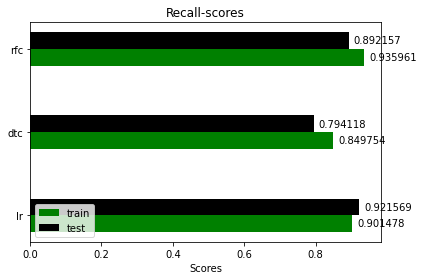

In [112]:
import numpy as np


train = [lr_scores['train'], dtc_scores['train'], rfc_scores['train']]
test = [lr_scores['test'], dtc_scores['test'], rfc_scores['test']]

models = ('lr', 'dtc', 'rfc')

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
train_bars = ax.barh(x - width/2, train, width, label='train', color='g')
test_bars = ax.barh(x + width/2, test, width, label='test', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Recall-scores')
ax.set_yticks(x, models)
ax.legend(loc="lower left")

ax.bar_label(train_bars, padding=5)
ax.bar_label(test_bars, padding=5)

fig.tight_layout()

plt.show()

**Insights**
- LR: De test doet het beter dan de train?? Dat is gek.
- DT: Dit ziet er goed uit. Geen sprake van over- of underfitting
- RFC: Ziet er prima uit.

Door een aantal hyperparameters van RFC te wijzigen en te verwijderen, hebben we de score kunnen verbeteren van 0.89 naar 0.91. Dit heeft meteen ook de overfitting probleem opgelost:

##### ROC-curve

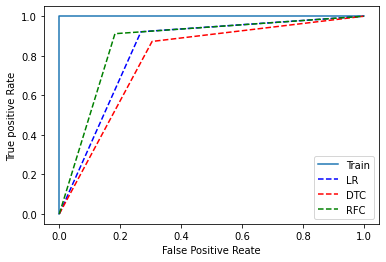

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_pred = lr.predict(X_test)
dtc_pred = dtc.predict(X_test)
rfc_pred = rfc.predict(X_test)


auc = roc_auc_score(y_test, lr_pred)

train_fpr, train_tpr, _ = roc_curve(y_test, y_test)

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
dtc_fpr, dtc_tpr, _ = roc_curve(y_test, dtc_pred)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_pred)

plt.plot()
plt.plot(train_fpr, train_tpr)
plt.plot(lr_fpr, lr_tpr, 'b--')
plt.plot(dtc_fpr, dtc_tpr, linestyle='--', color='red')
plt.plot(rfc_fpr, rfc_tpr, linestyle='--', color='green')
plt.legend(['Train', 'LR', 'DTC', 'RFC'])
plt.xlabel('False Positive Reate')
plt.ylabel('True positive Rate')

plt.show()

**Insights**
- Random Forst Classifier komt het dichtst bij de train rate. Wat je wilt hebben is dat je test lijn zo links boven mogelijk is. De oppervlakte onder de lijn moet zo groot mogelijk zijn. De RFC doet daat het best in. Dit zegt dus dat deze het minste False Positive heeft met hoogste True Positive Rate.

##### StandaardScaler

Om te beginnen, gebruiken we de modellen zonder enige parameters (exlusief random_state). Hiermee testen we even de StandaardScaler om de X data te scalen. Dit haalt de gemiddlede weg en zet elke waarde om in variance. De waardes scalen heeft zeker invloed gehad op zowel de recall en de accuracy score. Toch gaat het bij deze opdracht om alleen de recall score.

|                          | Recall | Recall met StandaardScaler | 
|--------------------------|--------|----------------------------|
| Logistic Regression      | 0.88   | 0.89                       |
| Decision Tree            | 0.72   | 0.83                       | 
| Random Forest Classifier | 0.85   | 0.87                       |

##### Parameters

Eerst had ik zelf met random parameters de modellen getest. De Recall-score bleef rond 0.82-0.86 zweven. Voor iedere model veranderde ik bijvoorbeeld de n_estimations, of max_depth etc. Uiteindelijk bedacht ik me dat we hier heel goed GridSearch kunnen toepassen. We kunnen zo heel snel de optimale parameters vinden.

Met behulp van RandomSearch en Gridsearch is er geprobeerd om de optimale parameters te vinden voor elke model.

Logistic Regression: C=0.001, random_state=11, solver='newton-cg

Decision Tree: max_depth=3, max_leaf_nodes=5

Random Forest: max_depth=15, max_features='sqrt', n_estimators=179, min_samples_split=6, min_samples_leaf=2, random_state=11 


|                          | Recall | Recall met beste parameters| 
|--------------------------|--------|----------------------------|
| Logistic Regression      | 0.89   | 0.92                       |
| Decision Tree            | 0.77   | 0.80                       | 
| Random Forest Classifier | 0.87   | 0.90                       |

##### Tijd

In [102]:
print(f"LR train tijd: {lr_train_time}")
print(f"DTC train tijd: {dt_train_time}")
print(f"RFC train tijd: {rf_train_time}")

LR train tijd: 0.003749847412109375
DTC train tijd: 0.001085042953491211
RFC train tijd: 0.040924072265625


**Insights**
- Decision Tree Classifier is het snelst
- Random Forest Classifier is het traagst

### Conclusie

De beste classifier komt volgens dit onderzoek op Logistic Regression. Zelf zat ik te twijfelen over Random Forest Classifier en Logistic Regression. Ik wist wel dat Logistic Regression hier goed bij zou passen, alleen had ik ook het voermoede dat Random Forest Classifier misschien beter zou werken als je de optimale parameters zou meegeven. Ik weet zeker dat ik de optimale parameters niet heb meegegeven (heb het wel zo goed mogelijk geprobeerd), maar je ziet wel de RFC wel heel dichtbij de LR score komt. Met betere parameters verwacht ik zelfs dat RFC het inhaalt.

Random Forest Classifier heeft wel de minste False Positives tegenover de True Positives. Dit geeft aan dat deze model bij dit probleem minder fouten maakt.

Door de kolommen Cholesterol en RestingECG uit de dataset te gooien, is zowel de recall score en de accuracy score van Logistic regression ietsjes verhoogd. De andere twee zijn zowat dezelfde gebleven. Is het het waard om de kolommen te verwijderen? meh. Je ziet niet echt veel verschil. Toch telt elke procent.

Qua tijd is Decision Tree het snelst. Hier ben ik wel verbaast over, aangezien LR juist sneller hoort te zijn. Toch denk ik dat dit gewoon te maken heeft met het feit data de dataset klein is. Bij grotere datasets denk ik wel dat LR sneller zal zijn. Dat RFC het traagst is, is wel duidelijk.

**Hoe kan je het verbeteren?**

- Uitschieters eruit halen. Er zijn sowieso nog uitschieters. Er zijn nog wat kolommen met z-scores > 3. 
- cross_validation toepassen. 
- Ik heb ook bijvoorbeeld bij cholesterol de 0 waardes vervangen met de mediaan. Misschien zijn andere methodes handiger. Dit zou te testen vallen.
- Last but not least, de RFC moeten we vaker runnen. Het is totaal gerandomized. Zo kwam een max_depth uit op 5, maar misschien zou een ander beter zijn geweest, die niet in de search voorbij kwam.

Ook heb ik een aantal paramters niet gebruikt. Misschien zouden die parameters wel van belang kunnen zijn met een combinatie van andere parameters. Zo heb ik bijvoorbeeld bij Logistic Regression de solver 'saga' niet gebruikt. Samen met een penalty van 'l2', kwam de recall op 100%. Dat is mooi! Maar waarom heb ik die er dan niet bijgezet? Nou, de accuracy van de model werd maar 50%... De true positives werd altijd 0! Hé! Daar hebben we helemaal niks aan! Zo zijn er wat aantal paramters die de accuracy heel erg omlaag halen, terwijl de recall score juist goed is. Daarom heb ik deze er express uitgehaald. 

Al met al, ik heb mooie resultaten bereikt met deze modellen. Een recall-score van 92% is niet niets.

### Bronnen
- https://researchpy.readthedocs.io/en/latest/ttest_documentation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
- https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832#:~:text=StandardScaler%20removes%20the%20mean%20and,standard%20deviation%20of%20each%20feature.
- https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python
- https://stackoverflow.com/questions/20229822/check-if-all-values-in-list-are-greater-than-a-certain-number
- https://datagy.io/python-z-score/